# Beer Data Analysis

#### Objective :

build a Machine Learning model which predicts the overall rating of the beer.

#### All features 

### 1. Data Preapration

In [1]:
# importing all needed libraries/packages
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error

In [2]:
# reading data
df = pd.read_csv("./train.csv")
df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


In [3]:
#getting information of data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthdayRaw   7856 non-null   object 
 16  user/birthdayUnix  785

In [4]:
# removing extra columns
df.drop(columns=['index', 'beer/beerId', 'beer/brewerId', 'review/timeStruct', 'review/timeUnix', 'user/birthdayRaw', 'user/birthdayUnix', 'user/profileName'], inplace=True)

In [5]:
#checking duplicates
df.duplicated().sum()

1

In [6]:
df.drop_duplicates(inplace=True) #removal of duplicates

In [7]:
df.duplicated().sum() # confirming the step

0

In [8]:
df["review/text"].isna().sum() # checking the null values in text column

10

In [9]:
df = df.dropna(subset=["review/text"])   # dropping null values

In [10]:
df["review/text"].isna().sum()   # confirming the step

0

### 2.  Feature Engineering

In [11]:
# creation of sentiment Polarity of text
analyser = SentimentIntensityAnalyzer()
def review_polarity(data):
    if data:
        score = analyser.polarity_scores(data)
        return score['compound']
    else:
        return "None"
    
df['review_sentiment'] = df["review/text"].map(review_polarity)
df['review_sentiment'].value_counts()

review_sentiment
 0.0000    81
 0.9892    63
 0.9906    63
 0.9885    60
 0.9694    58
           ..
-0.8047     1
 0.5776     1
-0.2877     1
-0.9128     1
-0.2193     1
Name: count, Length: 6924, dtype: int64

In [12]:
df.fillna({"user/gender": "unknown", 'user/ageInSeconds':df['user/ageInSeconds'].mean()}, inplace=True)  # Handling null vallues

In [13]:
df["user/gender"].isna().sum() # checking if there is any null value left

0

Label encoding of gender

0 --> Female

1 --> Male

2 --> Unknown

In [14]:
# Label Encoding the gender 
le = LabelEncoder()
df['user/gender'] = le.fit_transform(df['user/gender'])

In [15]:
df["user/ageInSeconds"].isna().sum() # checking the null values

0

In [16]:
df["user/ageInSeconds"] = df['user/ageInSeconds'] // 31536000  # Changing age in years

### 3. Balancing the Target Variable

In [17]:
df["review/overall"].value_counts()  # checking the data given according to target variable

review/overall
4.0    13867
4.5     8662
3.5     6549
3.0     3319
5.0     2667
2.5     1193
2.0      807
1.5      248
1.0      176
0.0        1
Name: count, dtype: int64

In [18]:
df.loc[df['review/overall'] == 0.0] 

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,user/ageInSeconds,user/gender,review_sentiment
17707,4.0,Pub Pils,Czech Pilsener,0.0,2.0,0.0,3.0,2.0,This is one of the most commercial tasting mic...,37.0,2,-0.777


In [19]:
# Identify indices where 'review/overall' is 0.0 and drop it as it is only one row
indices_to_drop = df[df['review/overall'] == 0.0].index
df = df.drop(indices_to_drop)


In [20]:
df_data = df.drop(columns=["review/overall"])  
df_label = df["review/overall"]

In [21]:
# labelling  overall rating data
df_label = df_label.apply(lambda x: 'Very Poor' if x == 1 else 
                                        'Poor' if x == 1.5 else
                                        'below average' if x == 2 else
                                        'average' if x == 2.5 else
                                        'slightly above average' if x == 3 else 
                                        'Good' if x == 3.5 else 
                                        'very good' if x == 4 else 
                                        'Excellent' if x == 4.5 else 'outstanding')

In [22]:
# Balancing data 
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
df1_resampled, label_resampled = ros.fit_resample(df_data, df_label)
df1_resampled.isna().sum()


beer/ABV             0
beer/name            0
beer/style           0
review/appearance    0
review/aroma         0
review/palate        0
review/taste         0
review/text          0
user/ageInSeconds    0
user/gender          0
review_sentiment     0
dtype: int64

### 4. Label Transformation

In [23]:
# Changing labels into integer
rating_label = {
    "Very Poor": 1.0,
    "Poor": 1.5,
    "below average": 2.0,
    "average": 2.5,
    "slightly above average": 3.0,
    "Good": 3.5,
    "very good": 4.0,
    "Excellent": 4.5,
    "outstanding": 5.0
}

labels_resampled = label_resampled.map(rating_label)
labels_resampled.isna().sum()

0

In [24]:
df = df1_resampled.join(labels_resampled) # getting balanced data

In [25]:
df

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/text,user/ageInSeconds,user/gender,review_sentiment,review/overall
0,5.0,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,37.0,2,0.0258,4.0
1,11.0,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,37.0,2,0.9390,3.5
2,4.7,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,37.0,1,0.8175,3.5
3,4.4,Pilsner Urquell,Czech Pilsener,3.0,3.0,3.0,3.0,First thing I noticed after pouring from green...,38.0,1,0.8625,2.5
4,4.4,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,37.0,2,0.9305,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
124798,4.4,Pilsner Urquell,Czech Pilsener,2.5,2.5,3.0,4.0,Golden body with a small white head that fell ...,37.0,2,0.5190,3.0
124799,6.0,Kirkwood Station Black Rye IPA,American IPA,3.5,3.5,3.5,3.0,Enjoyed on-tap @ the Kirkwood Station Brewing ...,37.0,2,0.6967,3.0
124800,4.8,Founders All Day IPA,American IPA,3.0,3.0,3.0,3.0,A- Pours a pretty clear golden yellow color wi...,36.0,1,0.7543,3.0
124801,6.5,Founders Harvest Ale,American IPA,4.0,4.0,3.5,3.5,Poured from a 12 oz bottle into a Westmalle go...,30.0,1,0.9495,3.0


#### Handling Rare Variables 

In [26]:
#creating another data for limiting the types of beer styles
beer = pd.DataFrame(df['beer/style'])
beer

,beer/style
0,Herbed / Spiced Beer
1,American Barleywine
2,American Pale Ale (APA)
3,Czech Pilsener
4,English Pale Ale
...,...
124798,Czech Pilsener
124799,American IPA
124800,American IPA
124801,American IPA


In [27]:
df["beer/style"].value_counts()

beer/style
American Double / Imperial Stout    12134
American Double / Imperial IPA       8508
American IPA                         6700
Rauchbier                            5501
Light Lager                          5471
                                    ...  
BiÃ¨re de Garde                        13
Berliner Weissbier                     13
Eisbock                                11
Lambic - Fruit                         10
Flanders Red Ale                        5
Name: count, Length: 95, dtype: int64

In [28]:
# limiting the types
rle = RareLabelEncoder(n_categories=1, max_n_categories=30, replace_with="others")
df['beer/style'] = rle.fit_transform(df[["beer/style"]])

df['beer/style'].value_counts()

beer/style
others                              97461
American Double / Imperial Stout    12134
American Double / Imperial IPA       8508
American IPA                         6700
Name: count, dtype: int64

In [29]:
df['beer/name'].value_counts()

beer/name
Amstel Light                               5113
Founders Breakfast Stout                   4591
Founders KBS (Kentucky Breakfast Stout)    4066
Pilsner Urquell                            3154
Aecht Schlenkerla Rauchbier MÃ¤rzen        2756
                                           ... 
Old Orange Cannonball                         1
Golden Orchid                                 1
Chattachoochee Brown Ale                      1
JuleÃ¸l                                       1
Mighty Tacoma Ale, V2                         1
Name: count, Length: 1688, dtype: int64

In [30]:
# limiting the beer names
beer_name = dict(df['beer/name'].value_counts() > 2000)
Beer_name = []
for i in df['beer/name']:
    if beer_name[i] == True:
        Beer_name.append(i)
    else:
        Beer_name.append("others")
df['beer/name'] = Beer_name
df['beer/name'].value_counts()

beer/name
others                                     95981
Amstel Light                                5113
Founders Breakfast Stout                    4591
Founders KBS (Kentucky Breakfast Stout)     4066
Pilsner Urquell                             3154
Aecht Schlenkerla Rauchbier MÃ¤rzen         2756
Founders Devil Dancer                       2713
Founders Backwoods Bastard                  2163
Founders Red's Rye PA                       2155
Founders Dirty Bastard                      2111
Name: count, dtype: int64

In [31]:
# One hot encoding of beer style
encoder = OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(df[['beer/style']]).toarray(), 
                       columns=encoder.get_feature_names_out(['beer/style']))
encoded.head()


,beer/style_American Double / Imperial IPA,beer/style_American Double / Imperial Stout,beer/style_American IPA,beer/style_others
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


In [32]:
df = df.join(encoded)

In [33]:
# one hot encoding of encoded names
encoded_names = pd.DataFrame(encoder.fit_transform(df[['beer/name']]).toarray(), 
                       columns=encoder.get_feature_names_out(['beer/name']))
df = df.drop(columns=encoded_names.columns.intersection(df.columns), errors='ignore')
df = df.join(encoded_names)
df.columns


Index(['beer/ABV', 'beer/name', 'beer/style', 'review/appearance',
       'review/aroma', 'review/palate', 'review/taste', 'review/text',
       'user/ageInSeconds', 'user/gender', 'review_sentiment',
       'review/overall', 'beer/style_American Double / Imperial IPA',
       'beer/style_American Double / Imperial Stout',
       'beer/style_American IPA', 'beer/style_others',
       'beer/name_Aecht Schlenkerla Rauchbier MÃ¤rzen',
       'beer/name_Amstel Light', 'beer/name_Founders Backwoods Bastard',
       'beer/name_Founders Breakfast Stout', 'beer/name_Founders Devil Dancer',
       'beer/name_Founders Dirty Bastard',
       'beer/name_Founders KBS (Kentucky Breakfast Stout)',
       'beer/name_Founders Red's Rye PA', 'beer/name_Pilsner Urquell',
       'beer/name_others'],
      dtype='object')

In [34]:
df.head()

,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/text,user/ageInSeconds,user/gender,...,beer/name_Aecht Schlenkerla Rauchbier MÃ¤rzen,beer/name_Amstel Light,beer/name_Founders Backwoods Bastard,beer/name_Founders Breakfast Stout,beer/name_Founders Devil Dancer,beer/name_Founders Dirty Bastard,beer/name_Founders KBS (Kentucky Breakfast Stout),beer/name_Founders Red's Rye PA,beer/name_Pilsner Urquell,beer/name_others
0,5.0,others,others,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,37.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,11.0,others,others,4.0,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,37.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4.7,others,others,3.5,4.0,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,37.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.4,Pilsner Urquell,others,3.0,3.0,3.0,3.0,First thing I noticed after pouring from green...,38.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.4,others,others,4.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,37.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
df.drop(columns=['beer/style', 'beer/name', 'review/text'], inplace=True) # removing extra columns

In [36]:
df.head()

,beer/ABV,review/appearance,review/aroma,review/palate,review/taste,user/ageInSeconds,user/gender,review_sentiment,review/overall,beer/style_American Double / Imperial IPA,...,beer/name_Aecht Schlenkerla Rauchbier MÃ¤rzen,beer/name_Amstel Light,beer/name_Founders Backwoods Bastard,beer/name_Founders Breakfast Stout,beer/name_Founders Devil Dancer,beer/name_Founders Dirty Bastard,beer/name_Founders KBS (Kentucky Breakfast Stout),beer/name_Founders Red's Rye PA,beer/name_Pilsner Urquell,beer/name_others
0,5.0,4.0,4.0,4.0,4.0,37.0,2,0.0258,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,11.0,4.0,3.5,3.5,3.0,37.0,2,0.9390,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4.7,3.5,4.0,3.5,3.5,37.0,1,0.8175,3.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.4,3.0,3.0,3.0,3.0,38.0,1,0.8625,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.4,4.0,3.0,3.5,2.5,37.0,2,0.9305,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 5. EDA(Exploratory Data Analysis)

In [37]:
corre_data = df.corr(numeric_only = True)  # correalation of data


<AxesSubplot: >

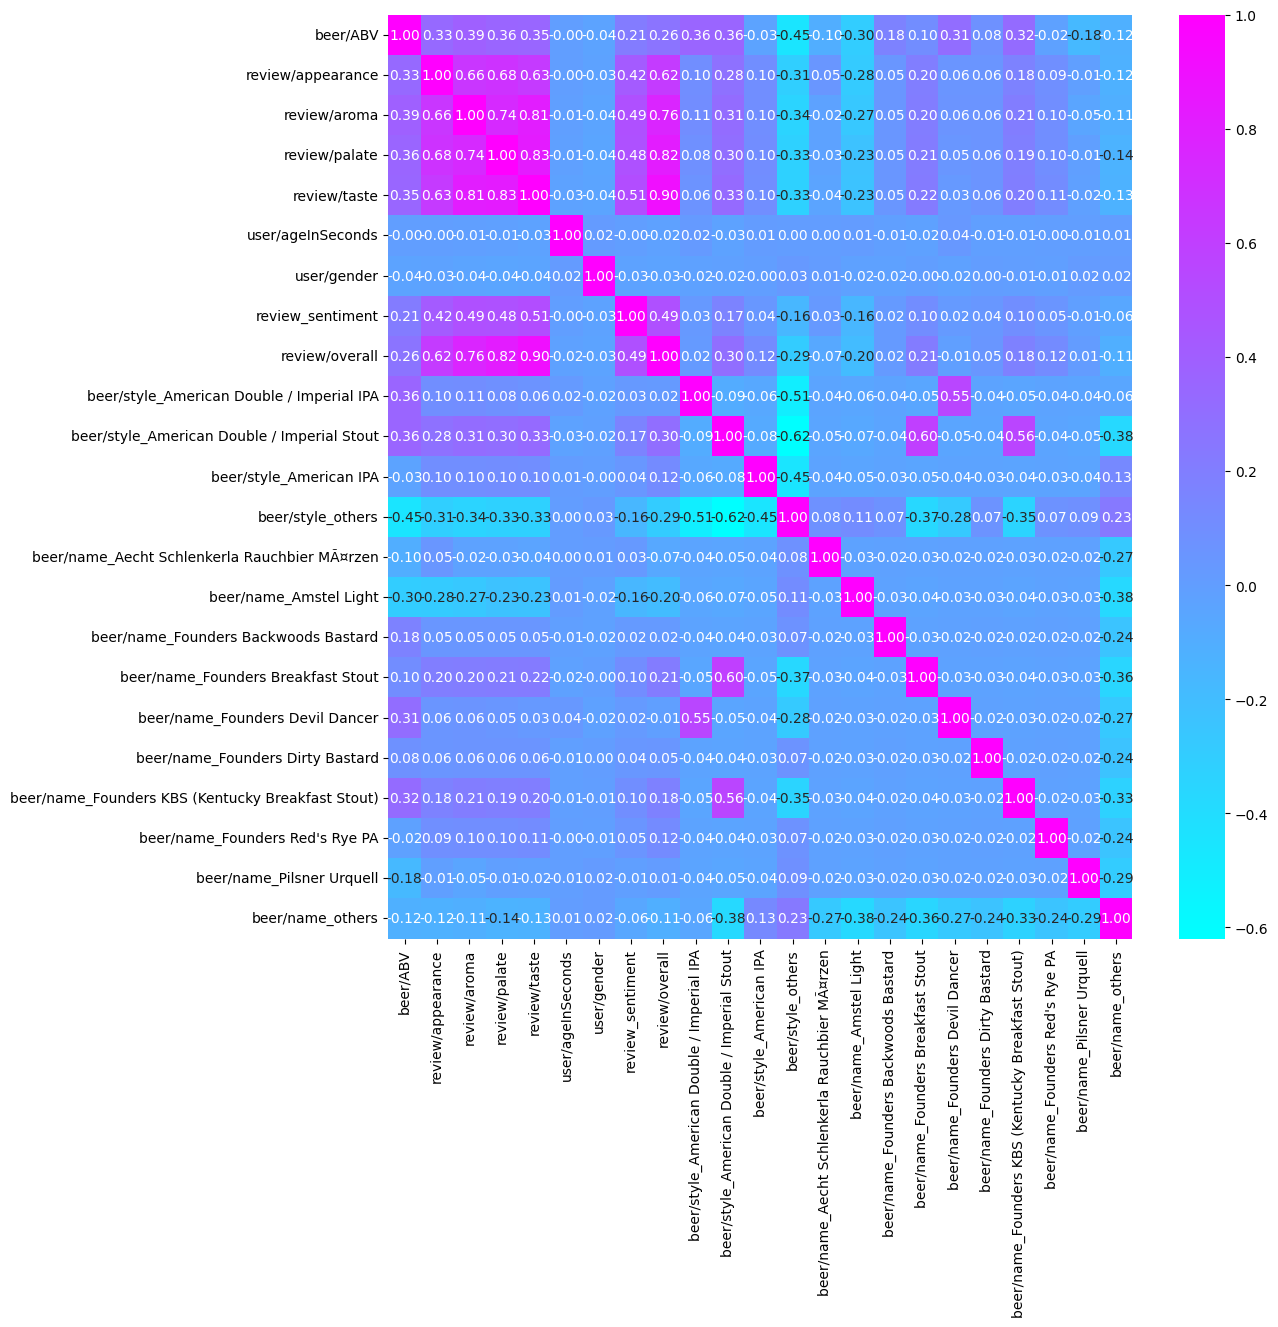

In [38]:
# visualising the correlation 
import seaborn as sns
plt.figure(figsize=(12,12))
sns.heatmap(corre_data, annot = True,cmap='cool', fmt='0.2f')

#### Fetures selected

### Model Training and Evaluation

In [39]:
X = df.drop(columns=["review/overall"])
y = df["review/overall"]

In [40]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40) # Splitting

In [41]:
print(X_train.shape, X_test.shape)

(87362, 22) (37441, 22)


In [42]:
print(y_train.shape, y_test.shape)

(87362,) (37441,)


### Model 1

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
y_prediction = lr.predict(X_test)
r2 = r2_score(y_prediction, y_test)
r2

0.8193106298274173

In [45]:
mse = mean_squared_error(y_prediction, y_test)
mse

0.25572947636760207

In [46]:
list(df.loc[5])

[10.0,
 4.0,
 4.0,
 4.0,
 4.5,
 37.0,
 2.0,
 0.7992,
 4.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0]

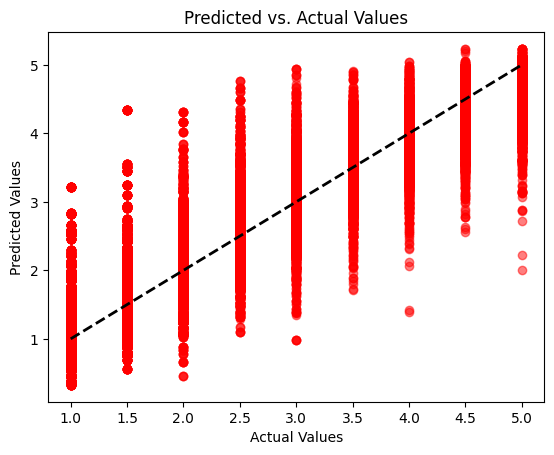

In [47]:
plt.scatter(y_test, y_prediction, color="red", alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.show()

In [48]:
df.columns

Index(['beer/ABV', 'review/appearance', 'review/aroma', 'review/palate',
       'review/taste', 'user/ageInSeconds', 'user/gender', 'review_sentiment',
       'review/overall', 'beer/style_American Double / Imperial IPA',
       'beer/style_American Double / Imperial Stout',
       'beer/style_American IPA', 'beer/style_others',
       'beer/name_Aecht Schlenkerla Rauchbier MÃ¤rzen',
       'beer/name_Amstel Light', 'beer/name_Founders Backwoods Bastard',
       'beer/name_Founders Breakfast Stout', 'beer/name_Founders Devil Dancer',
       'beer/name_Founders Dirty Bastard',
       'beer/name_Founders KBS (Kentucky Breakfast Stout)',
       'beer/name_Founders Red's Rye PA', 'beer/name_Pilsner Urquell',
       'beer/name_others'],
      dtype='object')

### Model 2
tried removing some variables to check the effect 

In [49]:
X1 = df.drop(columns=["review/overall", "user/ageInSeconds", 'user/gender'])
y1 = df["review/overall"]

In [50]:
 X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=40)

In [51]:
lr1 = LinearRegression()
lr1.fit(X_train1, y_train1)

LinearRegression()

In [52]:
y_prediction1 = lr1.predict(X_test1)
r2 = r2_score(y_prediction1, y_test1)
r2

0.8195175283162794

In [53]:
mse = mean_squared_error(y_prediction1, y_test1)
mse

0.25536507081435567

In [54]:
mae = mean_absolute_error(y_prediction1, y_test1)
mae

0.37726956453516713